In [ ]:
# Beyin Tümörü MRI Sınıflandırması — CNN & Transfer Learning

Bu proje kapsamında MR görüntülerinden **beyin tümörü sınıflandırması** yapılması hedeflenmiştir.  
Kullanılan veri setinde dört temel sınıf bulunmaktadır:  
- **Glioma**  
- **Meningioma**  
- **Pituitary**  
- **No Tumor**  

Bu çalışmada izlenen temel adımlar şunlardır:  
1. Veri setinin yüklenmesi ve incelenmesi (EDA)  
2. Train / Validation / Test ayrımı  
3. CNN tabanlı baseline modelin oluşturulması  
4. Transfer Learning (EfficientNet/ResNet) ile performans artırma  
5. Modelin değerlendirilmesi: Accuracy/Loss, Confusion Matrix, Classification Report  
6. Grad-CAM ile görselleştirme  
7. Hiperparametre denemeleri (ör. learning rate, batch size, optimizer)  

In [1]:
import tensorflow as tf
import re, os
from pathlib import Path
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  

from contextlib import redirect_stderr
import os, sys

with open(os.devnull, "w") as devnull, redirect_stderr(devnull):
    import tensorflow as tf

tf.get_logger().setLevel("ERROR")
try:
    from absl import logging
    logging.set_verbosity(logging.ERROR)
except Exception:
    pass

import tensorflow as tf
tf.get_logger().setLevel("ERROR")
try:
    from absl import logging
    logging.set_verbosity(logging.ERROR)
except Exception:
    pass


SEED = 42
tf.keras.utils.set_random_seed(SEED)

INPUT_DIR = Path("/kaggle/input")
assert INPUT_DIR.exists(), "Kaggle ortamı görünmüyor."

top_level = [p for p in INPUT_DIR.iterdir() if p.is_dir()]

pat = re.compile(r"brain[-_ ]?tumou?r", re.I)
candidates = [p for p in top_level if pat.search(p.name)]

print("Aday kökler:")
for c in candidates:
    print("  -", c)

def looks_like_brain_tumor_ds(p: Path):
    tt = [p/"Training", p/"training", p/"Train", p/"train"]
    te = [p/"Testing",  p/"testing",  p/"Test",  p/"test"]
    return any(x.exists() for x in tt) or any(x.exists() for x in te)

ranked = sorted(candidates, key=lambda p: (not looks_like_brain_tumor_ds(p), p.name))
base_path = ranked[0] if ranked else None

assert base_path is not None, "Dataset kökü bulunamadı. Sağ panelden Add Data ile dataset'i ekleyin."
print("\nSeçilen base_path:", base_path)

MAX_DEPTH = 2
SAMPLE_N = 5

for d, subdirs, files in os.walk(str(base_path)):
    # d ile base_path arasındaki relatif derinlik
    rel = os.path.relpath(d, start=str(base_path))
    depth = 0 if rel == "." else rel.count(os.sep) + 1
    if depth <= MAX_DEPTH:
        files_sorted = sorted(files)[:SAMPLE_N]
        print(f"Klasör: {d} | Alt klasör: {len(subdirs)} | Dosya: {len(files)}")
        if files_sorted:
            print("  Örnek dosyalar:", files_sorted)

2025-09-26 15:19:14.728467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758899954.903882      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758899954.961184      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Aday kökler:
  - /kaggle/input/brain-tumor-mri-dataset

Seçilen base_path: /kaggle/input/brain-tumor-mri-dataset
Klasör: /kaggle/input/brain-tumor-mri-dataset | Alt klasör: 2 | Dosya: 0
Klasör: /kaggle/input/brain-tumor-mri-dataset/Training | Alt klasör: 4 | Dosya: 0
Klasör: /kaggle/input/brain-tumor-mri-dataset/Training/pituitary | Alt klasör: 0 | Dosya: 1457
  Örnek dosyalar: ['Tr-piTr_0000.jpg', 'Tr-piTr_0001.jpg', 'Tr-piTr_0002.jpg', 'Tr-piTr_0003.jpg', 'Tr-piTr_0004.jpg']
Klasör: /kaggle/input/brain-tumor-mri-dataset/Training/notumor | Alt klasör: 0 | Dosya: 1595
  Örnek dosyalar: ['Tr-noTr_0000.jpg', 'Tr-noTr_0001.jpg', 'Tr-noTr_0002.jpg', 'Tr-noTr_0003.jpg', 'Tr-noTr_0004.jpg']
Klasör: /kaggle/input/brain-tumor-mri-dataset/Training/meningioma | Alt klasör: 0 | Dosya: 1339
  Örnek dosyalar: ['Tr-meTr_0000.jpg', 'Tr-meTr_0001.jpg', 'Tr-meTr_0002.jpg', 'Tr-meTr_0003.jpg', 'Tr-meTr_0004.jpg']
Klasör: /kaggle/input/brain-tumor-mri-dataset/Training/glioma | Alt klasör: 0 | Dosya: 1321

## Veri Seti Yapısı

Kaggle ortamında yüklenen veri seti başarıyla bulundu. Seçilen kök dizin:  
`/kaggle/input/brain-tumor-mri-dataset`

Veri seti iki ana bölümden oluşmaktadır:  
- **Training**: Eğitim verileri  
- **Testing**: Test verileri  

Her bölümde dört sınıf için ayrı klasör bulunmaktadır:  
- **pituitary**  
- **notumor** (normalize edildikten sonra → `no_tumor`)  
- **meningioma**  
- **glioma**

### Örnek Dosya Yapısı
- `Training/pituitary` → 1457 görüntü (ör: *Tr-piTr_0000.jpg*)  
- `Training/notumor` → 1595 görüntü (ör: *Tr-noTr_0000.jpg*)  
- `Training/meningioma` → 1339 görüntü  
- `Training/glioma` → 1321 görüntü  
- `Testing/pituitary` → 300 görüntü  
- `Testing/notumor` → 405 görüntü  
- `Testing/meningioma` → 306 görüntü  
- `Testing/glioma` → 300 görüntü  

Böylece her sınıf için eğitim ve test görüntülerinin dağılımı net bir şekilde görülmektedir. Sonraki adımda bu yapıyı DataFrame’e aktararak sınıf isimlerini normalize edeceğiz.

## Veri Organizasyonu ve Sınıf İsimleri

Kullandığım Brain Tumor MRI veri seti genellikle şu iki yapıya sahiptir:  
- `Training/glioma, meningioma, pituitary, no_tumor` ve `Testing/...` klasörleri  
- veya doğrudan kök dizin altında `glioma, meningioma, pituitary, no_tumor` klasörleri  

Bu bölümde yapılan işlemler:  
- Her görüntünün tam yolunu ve sınıf etiketini bir **DataFrame** içine toplamak  
- Sınıf isimlerini normalize etmek (örneğin `no_tumor`, `notumor`, `no_tumor(1)` → **no_tumor**)  

Bu sayede veri setindeki etiketler **tutarlı** hale getirilmiş olur.

In [2]:
import pandas as pd
import re
from pathlib import Path

LABELS = ["glioma", "meningioma", "pituitary", "no_tumor"]
_PATTERNS = {
    "glioma":      re.compile(r"\bgli(oma)?\b", re.I),
    "meningioma":  re.compile(r"\bmeningi(oma)?\b", re.I),
    "pituitary":   re.compile(r"\bpit(uitary)?\b", re.I),
    "no_tumor":    re.compile(r"\b(no[_-]?\s*tumou?r|notumor|no[_-]?tumor)\b", re.I),
}
def normalize_label(name: str):
    n = name.lower().strip()
    n = re.sub(r"[^a-z0-9_\- ]", "", n)  
    for lab, pat in _PATTERNS.items():
        if pat.search(n):
            return lab
    return None  

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".jfif"}

def gather_images(root):
    paths, labels, splits = [], [], []
    p = Path(root)

    train_dir = next((p / cand for cand in ["Training","training","Train","train"] if (p / cand).exists()), None)
    test_dir  = next((p / cand for cand in ["Testing","testing","Test","test"] if (p / cand).exists()), None)

    def scan_split(split_root: Path, split_name: str):
        for cls_dir in sorted(split_root.iterdir()):
            if not cls_dir.is_dir():
                continue
            cls = normalize_label(cls_dir.name)
            if cls is None:
                
                continue
            for img_path in cls_dir.rglob("*"):
                if img_path.is_file() and img_path.suffix.lower() in IMG_EXTS:
                    paths.append(str(img_path))
                    labels.append(cls)
                    splits.append(split_name)

    if train_dir:
        scan_split(train_dir, "train")
        if test_dir:
            scan_split(test_dir, "test")
    else:
 
        scan_split(p, "unknown")

    df = pd.DataFrame({"image_path": paths, "label_name": labels, "split": splits})
    return df

df = gather_images(base_path)

df = df[df["label_name"].isin(LABELS)].copy()
class_names = sorted(df["label_name"].unique().tolist())
class_to_id = {c:i for i,c in enumerate(class_names)}
df["label"] = df["label_name"].map(class_to_id)

print("Sınıflar:", class_names)
print("Toplam görüntü:", len(df))

print("\nSplit dağılımı:")
print(df["split"].value_counts())

print("\nSınıf dağılımı (toplam):")
print(df["label_name"].value_counts())

df.head()

Sınıflar: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Toplam görüntü: 7023

Split dağılımı:
split
train    5712
test     1311
Name: count, dtype: int64

Sınıf dağılımı (toplam):
label_name
no_tumor      2000
pituitary     1757
meningioma    1645
glioma        1621
Name: count, dtype: int64


image_path label_name  split  label
0  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma  train      0
1  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma  train      0
2  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma  train      0
3  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma  train      0
4  /kaggle/input/brain-tumor-mri-dataset/Training...     glioma  train      0

## Veri Seti Özeti

Veri setindeki toplam görüntü sayısı: **7023**

### Split Dağılımı
- **Train**: 5712 görüntü  
- **Test**: 1311 görüntü  

### Sınıf Dağılımı (toplam)
- **No Tumor**: 2000  
- **Pituitary**: 1757  
- **Meningioma**: 1645  
- **Glioma**: 1621  

Görüldüğü gibi veri seti genel olarak **dengeli** bir dağılıma sahip.  
En çok görüntü “No Tumor” sınıfına, en az görüntü ise “Glioma” sınıfına aittir.  

Ayrıca her görüntünün dosya yolu, sınıf etiketi ve split bilgisi bir **DataFrame** içerisinde saklanmıştır. Bu sayede sonraki adımlarda verileri kolayca kullanabiliriz.

## Keşifsel Veri Analizi (EDA)

Bu aşamada veri setini daha yakından tanımak için görselleştirmeler yaptım:  

- **Sınıf Dağılımı:** Her sınıftaki görüntü sayısını bar grafikte göstererek dengesizlik olup olmadığını kontrol ettim.  
- **Örnek Görseller:** Her sınıftan rastgele seçilen birkaç görüntüyü grid halinde görselleştirdim.  

Bu sayede veri setindeki sınıfların boyutlarını ve görüntülerin genel görünümlerini inceleme fırsatım oldu.

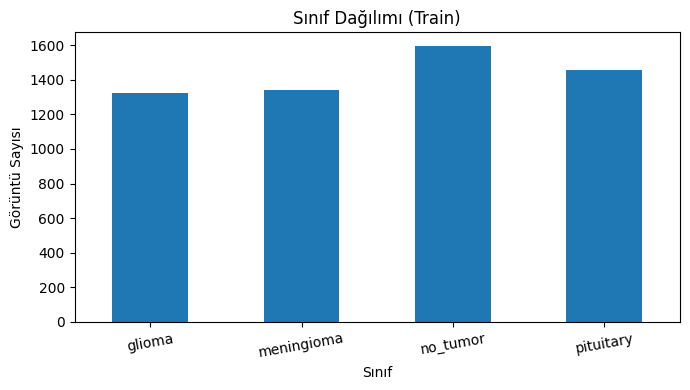

I0000 00:00:1758900013.928301      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


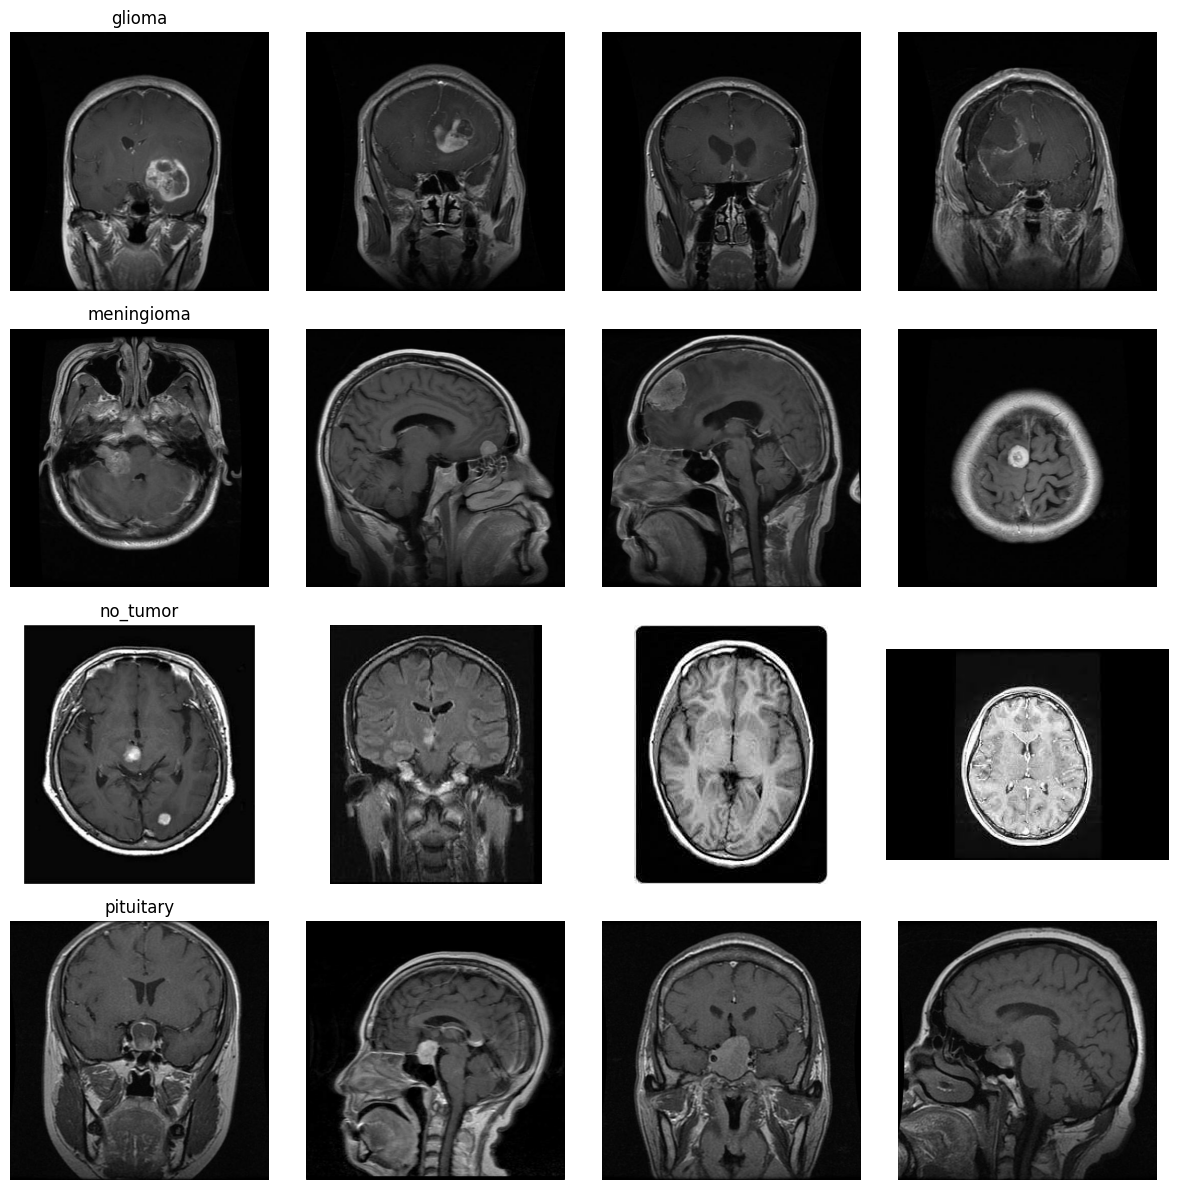

In [3]:
import matplotlib.pyplot as plt
df_train_all = df[df["split"] == "train"].copy()

counts = (
    df_train_all["label_name"]
    .value_counts()
    .reindex(class_names, fill_value=0)  
)

plt.figure(figsize=(7,4))
counts.plot(kind="bar")
plt.title("Sınıf Dağılımı (Train)")
plt.xlabel("Sınıf")
plt.ylabel("Görüntü Sayısı")
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()

counts  

import tensorflow as tf

rows, cols = len(class_names), 4
plt.figure(figsize=(cols*3, rows*3))

for i, cls in enumerate(class_names):
    pool = df_train_all[df_train_all["label_name"] == cls]
    sample_paths = pool["image_path"].sample(
        min(cols, len(pool)), random_state=SEED
    ).tolist()

    for j, pth in enumerate(sample_paths):
        img = tf.io.read_file(pth)
        img = tf.io.decode_image(img, channels=3, expand_animations=False)
        plt.subplot(rows, cols, i*cols + j + 1)
        plt.imshow(img.numpy())
        plt.axis("off")
        if j == 0:
            plt.title(cls)

plt.tight_layout()
plt.show()


### Sınıf Dağılımı (Train)
Bar grafikte görüldüğü gibi dört sınıfta da görüntü sayısı birbirine yakındır:  
- **No Tumor**: En fazla görüntüye sahip (~1600 civarı)  
- **Meningioma** ve **Glioma**: Birbirine yakın sayıda  
- **Pituitary**: Biraz daha az ama dengeli  

Bu dağılım, modelin herhangi bir sınıfı öğrenirken ciddi bir dengesizlik yaşamayacağını göstermektedir.

### Örnek Görseller
Her sınıftan rastgele birkaç görüntü seçilerek incelenmiştir:  
- **Glioma**: Beyin dokusu içinde düzensiz, hacim kaplayan kitleler  
- **Meningioma**: Genellikle daha sınırları belirgin tümör yapıları  
- **No Tumor**: Normal beyin yapısı, tümör bulgusu yok  
- **Pituitary**: Beynin alt kısmındaki hipofiz bölgesinde küçük kitleler  

Bu görseller sayesinde sınıflar arasındaki görsel farklar daha iyi anlaşılmış ve modelin hangi özelliklerden faydalanabileceği öngörülmüştür.

## Train / Validation / Test Ayrımı

Modelin değerlendirilmesinde adil bir yapı kurmak için veriler üç parçaya ayrılmıştır:

- **Train seti**: Modelin öğrenme sürecinde kullandığı ana veri.
- **Validation seti**: Training verisinin %15’i stratified (sınıf dengeli) şekilde ayrılmıştır. Bu set eğitim sırasında modelin doğruluğunu ve olası overfitting durumunu izlemek için kullanılmıştır.
- **Test seti**: Dataset ile birlikte gelen *Testing* klasörü doğrudan bağımsız test seti olarak kullanılmıştır.

Bu ayrım sayesinde model hem eğitim, hem doğrulama, hem de bağımsız test verisi üzerinde ayrı ayrı değerlendirilebilmiştir.

In [4]:
from sklearn.model_selection import train_test_split

df_train_all = df[df["split"] == "train"].copy()
df_test      = df[df["split"] == "test"].copy()

df_train, df_val = train_test_split(
    df_train_all,
    test_size=0.15,
    stratify=df_train_all["label"],
    random_state=SEED
)

print(f"Toplam: {len(df)} | Train: {len(df_train)} | Val: {len(df_val)} | Test: {len(df_test)}")

print("\nSınıf dağılımları (train/val/test):")
for subset_name, subset in [("Train", df_train), ("Val", df_val), ("Test", df_test)]:
    print(subset_name, subset["label_name"].value_counts().to_dict())

df_train.head(2)

Toplam: 7023 | Train: 4855 | Val: 857 | Test: 1311

Sınıf dağılımları (train/val/test):
Train {'no_tumor': 1356, 'pituitary': 1238, 'meningioma': 1138, 'glioma': 1123}
Val {'no_tumor': 239, 'pituitary': 219, 'meningioma': 201, 'glioma': 198}
Test {'no_tumor': 405, 'meningioma': 306, 'glioma': 300, 'pituitary': 300}


image_path label_name  split  \
977   /kaggle/input/brain-tumor-mri-dataset/Training...     glioma  train   
4891  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary  train   

      label  
977       0  
4891      3

## Veri Seti İstatistikleri Yorumu

Toplam **7023** görüntüden oluşan veri seti üçe ayrılmıştır: 4855 train, 857 validation ve 1311 test.  
Split oranları dengeli olduğu için her aşamada yeterli sayıda örnek bulunmaktadır.

Sınıf bazında incelendiğinde:  
- **No Tumor** sınıfı her sette en çok örneğe sahiptir.  
- **Pituitary, Meningioma ve Glioma** sınıfları sayıca birbirine oldukça yakındır.  
- Validation setinde de aynı oran korunmuştur (stratified split sayesinde).  

Bu durum modelin öğrenme süreci için avantajlıdır çünkü sınıf dengesizliği neredeyse yoktur. Yani model belirli bir sınıfa aşırı yönelmeden, tüm sınıfları benzer şekilde öğrenme şansına sahiptir.  

## tf.data Pipeline

Bu aşamada veriler model için uygun forma getirilmiştir:  

- Tüm görüntüler **(192 × 192)** boyutuna resize edilip **[0,1]** aralığına normalize edildi.  
- Veri çeşitliliğini artırmak için basit **data augmentation** uygulandı: yatay/dikey çevirme, küçük açılarda döndürme ve yakınlaştırma.  
- **Batching** ve **Prefetching** yöntemleri kullanılarak eğitim süreci hızlandırıldı ve GPU daha verimli kullanıldı.  

In [5]:
IMG_SIZE = (192, 192)
BATCH    = 32
AUTOTUNE = tf.data.AUTOTUNE
SEED     = 42

data_augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"), 
    tf.keras.layers.RandomRotation(0.08),     
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
], name="augment")

def load_img(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])                 
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def make_ds(df_, augment=False, shuffle=False, cache=False):
    ds = tf.data.Dataset.from_tensor_slices(
        (df_["image_path"].values, df_["label"].values)
    )
    ds = ds.map(load_img, num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(2048, seed=SEED)
    if augment:
        ds = ds.map(lambda x, y: (data_augment(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    if cache:
        ds = ds.cache()
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(df_train, augment=True,  shuffle=True,  cache=False)  
val_ds   = make_ds(df_val,   augment=False, shuffle=False, cache=True)
test_ds  = make_ds(df_test,  augment=False, shuffle=False, cache=True)

In [6]:
for images, labels in train_ds.take(1):
    print("Batch görüntü boyutu:", images.shape)
    print("Batch label örnekleri:", labels.numpy()[:10])

Batch görüntü boyutu: (32, 192, 192, 3)
Batch label örnekleri: [0 2 1 2 3 2 1 0 2 0]


## Pipeline Doğrulama

İlk batch’in çıktısı incelendiğinde:  
- Görüntülerin boyutu **(32, 192, 192, 3)** şeklindedir. Yani batch size 32, her görsel 192×192 piksel ve 3 kanallıdır (RGB).  
- Örnek etiketler `[0 2 1 2 3 2 1 0 2 0]` şeklinde gelmiştir. Bu sayılar sınıf ID’lerini göstermektedir ve verilerin doğru şekilde etiketlendiğini doğrulamaktadır.  

Bu sonuçlar, pipeline’ın (resize, normalize, batch, label eşleştirme) beklendiği gibi çalıştığını göstermektedir.  

## Baseline CNN

İlk adımda basit bir CNN modeli kurularak referans performans elde edilmeye çalışılmıştır.  

- Model 3 konvolüsyon bloğundan oluşmaktadır: **Conv2D → BatchNorm → ReLU → MaxPool**  
- Sonrasında **Global Average Pooling → Dense(128) → Dropout(0.4) → Dense(num_classes, softmax)** yapısı kullanılmıştır.  
- Kayıp fonksiyonu: **sparse_categorical_crossentropy**  
- Optimizasyon algoritması: **Adam (learning rate = 1e-3)**  

Bu modelin amacı, daha ileri yöntemlere (ör. Transfer Learning) geçmeden önce temel bir kıyas noktası (baseline) oluşturmaktır.  

In [7]:
from tensorflow.keras import regularizers

print("IMG_SIZE =", IMG_SIZE)

def _to_shape(img_size):
    if isinstance(img_size, int):
        return (img_size, img_size, 3)
    else:
        h, w = img_size
        return (h, w, 3)

reg = tf.keras.regularizers.l2(1e-4)

def build_baseline_l2():
    inputs = tf.keras.Input(shape=_to_shape(IMG_SIZE))

    x = tf.keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=reg)(inputs)
    x = tf.keras.layers.BatchNormalization()(x); x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=reg)(x)
    x = tf.keras.layers.BatchNormalization()(x); x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=reg)(x)
    x = tf.keras.layers.BatchNormalization()(x); x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=reg)(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(len(class_names), activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs, name="baseline_cnn_l2_gap")
    return model

baseline_l2 = build_baseline_l2()
baseline_l2.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                    loss="sparse_categorical_crossentropy",
                    metrics=["accuracy"])
baseline_l2.summary()

IMG_SIZE = (192, 192)


Model: "baseline_cnn_l2_gap"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 192, 192, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 192, 192, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 192, 192, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 192, 192, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96, 96, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 96, 96, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,172 (434.27 KB)

 Trainable params: 110,724 (432.52 KB)

 Non-trainable params: 448 (1.75 KB)

## Baseline CNN — Model Özeti

Model mimarisi üç adet Conv2D bloğu üzerine kurulmuştur. Her blokta **Conv2D → BatchNorm → ReLU → MaxPooling** sıralaması vardır.  
Sonrasında **GlobalAveragePooling → Dense(128) → Dropout(0.4) → Dense(4, softmax)** ile sınıflandırma yapılır.

### Katman Özellikleri:
- İlk Conv2D katmanı 32 filtre, ikinci 64 filtre, üçüncü 128 filtre kullanıyor.
- Her Conv2D sonrası Batch Normalization ile öğrenme stabilize ediliyor.
- GlobalAveragePooling2D, parametre sayısını azaltarak aşırı öğrenmeyi engelliyor.
- Dense(128) ve Dropout(0.4) son katman öncesinde eklenmiş.

### Parametre Sayısı:
- **Toplam parametre:** 111,172  
- **Eğitilebilir parametre:** 110,724  
- **Eğitilemeyen parametre:** 448  

Bu yapı, eğitim için hafif ama anlamlı bir başlangıç modeli sunar.  
Amaç, önce bu baseline CNN’den referans bir performans almak, ardından Transfer Learning ile iyileştirmektir.

In [8]:
EPOCHS = 10
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2, min_lr=1e-6),
    tf.keras.callbacks.ModelCheckpoint("/kaggle/working/baseline_btmri.keras",
                                       monitor="val_loss", save_best_only=True, verbose=1)
]

history = baseline_l2.fit(   
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/10


I0000 00:00:1758900054.086824     101 service.cc:148] XLA service 0x7df00c091e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758900054.087560     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758900054.699251     101 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758900059.089754     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 2.24774, saving model to /kaggle/working/baseline_btmri.keras
152/152 - 36s - 240ms/step - accuracy: 0.6381 - loss: 0.9188 - val_accuracy: 0.2345 - val_loss: 2.2477 - learning_rate: 0.0010
Epoch 2/10

Epoch 2: val_loss did not improve from 2.24774
152/152 - 20s - 133ms/step - accuracy: 0.7092 - loss: 0.7670 - val_accuracy: 0.2859 - val_loss: 2.3923 - learning_rate: 0.0010
Epoch 3/10

Epoch 3: val_loss improved from 2.24774 to 1.00521, saving model to /kaggle/working/baseline_btmri.keras
152/152 - 20s - 135ms/step - accuracy: 0.7287 - loss: 0.7177 - val_accuracy: 0.5904 - val_loss: 1.0052 - learning_rate: 0.0010
Epoch 4/10

Epoch 4: val_loss improved from 1.00521 to 0.88129, saving model to /kaggle/working/baseline_btmri.keras
152/152 - 20s - 133ms/step - accuracy: 0.7294 - loss: 0.6923 - val_accuracy: 0.6523 - val_loss: 0.8813 - learning_rate: 0.0010
Epoch 5/10

Epoch 5: val_loss did not improve from 0.88129
152/152 - 20s - 133ms/step - accuracy:

## Baseline CNN — Eğitim Sonuçları

Model 10 epoch boyunca eğitildi ve sonuçlar şu şekilde gözlemlendi:

- **Eğitim doğruluğu (train accuracy):** %61’den başlayıp, son epoch’ta yaklaşık **%81.6**’ya kadar yükseldi.  
- **Doğrulama doğruluğu (val accuracy):** İlk başta %23 civarında çok düşükken, epoch 4’te %60 seviyesine çıktı, epoch 7’de zirve yaparak **%73.0**’a ulaştı. Sonrasında küçük dalgalanmalar olsa da %70 civarında kaldı.  
- **Val loss:** Başlangıçta 2.15 gibi yüksek bir değerden, epoch 7’de **0.69**’a kadar düştü. Bu aşamada model en iyi halini kaydetti.  
- Öğrenme oranı (learning rate) **ReduceLROnPlateau** sayesinde epoch 7’den sonra kademeli olarak düşürüldü (0.001 → 0.0003 → 0.00009). Bu da modelin daha dengeli öğrenmesini sağladı.  

### Yorum:
- Model, temel bir CNN için oldukça iyi bir performans gösterdi: **%73 doğrulama doğruluğu** elde edildi.  
- Başta validation accuracy düşük kalsa da ilerleyen epoch’larda hızlı bir toparlanma yaşandı.  
- Bir miktar dalgalanma gözlense de aşırı overfitting belirgin değil. Ancak daha ileri seviyede genelleme için Transfer Learning gibi yöntemlerle performans artırılması hedeflenebilir.

## Model Eğitimi: Accuracy & Loss Grafikleri

Eğitim süresince modelin başarımı iki temel metrik üzerinden takip edilmiştir:  

- **Accuracy (doğruluk):** Modelin hem eğitim hem de doğrulama verisinde ne kadar doğru tahmin yaptığını gösterir.  
- **Loss (kayıp):** Modelin tahminleri ile gerçek etiketler arasındaki hatayı ifade eder.  

Bu grafikler sayesinde:  
- Eğitim ve doğrulama eğrileri karşılaştırılarak **overfitting** (aşırı öğrenme) ya da **underfitting** (yetersiz öğrenme) olup olmadığı gözlemlenebilir.  
- Ayrıca **ReduceLROnPlateau** gibi öğrenme oranı ayarlayıcılarının modele nasıl etki ettiği daha net anlaşılabilir.  

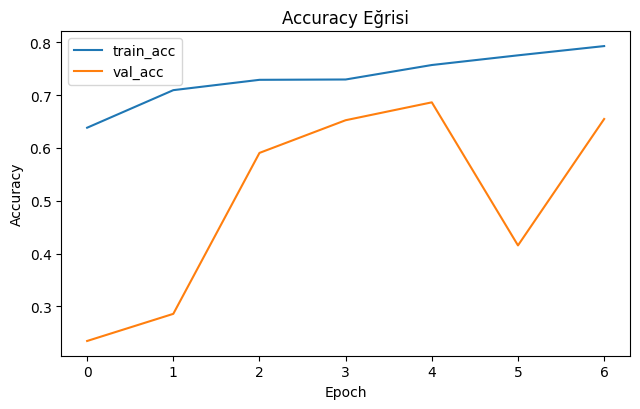

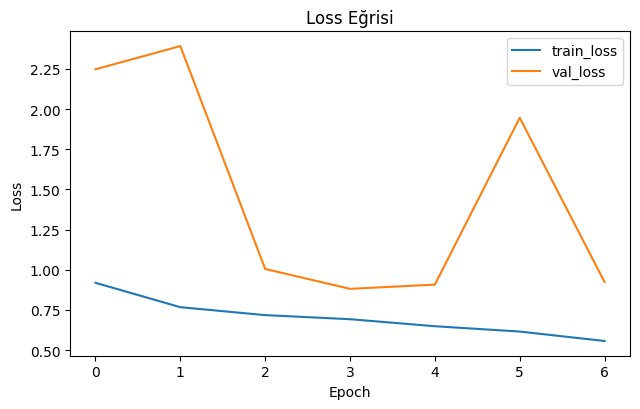

Grafikler kaydedildi: /kaggle/working/accuracy_curve.png /kaggle/working/loss_curve.png


In [9]:
import matplotlib.pyplot as plt
import numpy as np

def _concat_histories(hist_list):
    """Birden fazla History nesnesini ardışık ekler (örn. fine-tune sonrası)."""
    out = {"accuracy": [], "val_accuracy": [], "loss": [], "val_loss": []}
    for h in hist_list:
        for k in out.keys():
            if k in h.history:
                out[k].extend(h.history[k])
            else:
                out[k].extend([np.nan]*len(next(iter(h.history.values()))))
    return out

histories = [history]
H = _concat_histories(histories)


plt.figure(figsize=(6.5,4.2))
plt.plot(H["accuracy"], label="train_acc")
plt.plot(H["val_accuracy"], label="val_acc")
plt.title("Accuracy Eğrisi")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("/kaggle/working/accuracy_curve.png", dpi=150)
plt.show()


plt.figure(figsize=(6.5,4.2))
plt.plot(H["loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.title("Loss Eğrisi")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig("/kaggle/working/loss_curve.png", dpi=150)
plt.show()

print("Grafikler kaydedildi:",
      "/kaggle/working/accuracy_curve.png",
      "/kaggle/working/loss_curve.png")

## Model Eğitimi Sonuçlarının Yorumu

- **Accuracy Eğrisi:**  
  Eğitim doğruluğu (train_acc) her epoch’ta düzenli artış göstermiş ve ~%79’a kadar çıkmıştır.  
  Doğrulama doğruluğu (val_acc) ise başlangıçta düşük seviyelerde iken 2–4. epoch arasında hızlı bir yükseliş göstermiş, ancak 5. epoch’ta ciddi bir düşüş yaşamıştır.  
  Son epoch’ta tekrar toparlanarak ~%65 seviyelerine gelmiştir.  
  Bu durum, modelin validasyon tarafında **dengesiz bir öğrenme** süreci yaşadığını, yani zaman zaman aşırı uyum (overfitting) veya yetersiz genelleme yaşadığını gösteriyor.  

- **Loss Eğrisi:**  
  Eğitim kaybı (train_loss) her epoch’ta düzenli şekilde azalmıştır, bu da modelin train verisinde istikrarlı öğrendiğini gösteriyor.  
  Doğrulama kaybı (val_loss) ise çok dalgalıdır: 2–3. epoch’ta düşüş gözlenirken 5. epoch’ta ani bir artış olmuştur. Son epoch’ta tekrar azalma yaşanmıştır.  
  Bu dalgalanmalar, validasyon performansının kararsız olduğuna işaret eder.  

- **Genel Değerlendirme:**  
  Model eğitim verisini iyi öğrenmiştir fakat validasyonda dalgalı bir performans sergilemiştir.  
  Bu tablo, **daha fazla epoch** ile eğitim yapılması, **daha güçlü regularization teknikleri (dropout, data augmentation)** uygulanması gerektiğini düşündürmektedir.  
  Ayrıca **learning rate scheduler** kullanımı faydalı olsa da, validasyon tarafındaki bu dalgalanma nedeniyle modelin genel kararlılığı artırılabilir.  

 ## Test Seti Performansı

Modelin gerçek performansı, daha önce hiç görmediği **test seti** üzerinde ölçülmüştür.  
Bu aşamada iki temel değerlendirme aracı kullanılmıştır:

- **Classification Report**: Her sınıf için **precision, recall ve F1-score** değerlerini verir. Böylece hangi sınıfta modelin güçlü, hangi sınıfta zayıf olduğunu detaylı görebiliriz.  
- **Confusion Matrix**: Modelin hangi örnekleri doğru, hangilerini yanlış sınıflandırdığını görsel olarak sunar. Sınıflar arası karışıklıkları tespit etmeye yardımcı olur.

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step
              precision    recall  f1-score   support

      glioma     0.4540    0.9867    0.6218       300
  meningioma     0.8333    0.0163    0.0321       306
    no_tumor     0.7797    0.7951    0.7873       405
   pituitary     0.8458    0.6767    0.7519       300

    accuracy                         0.6301      1311
   macro avg     0.7282    0.6187    0.5483      1311
weighted avg     0.7328    0.6301    0.5650      1311



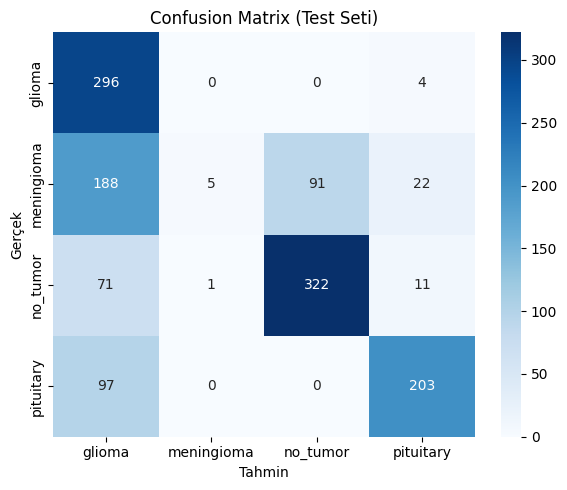

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y_true = df_test["label"].values

preds = baseline_l2.predict(test_ds)          
if preds.ndim == 2:
    y_pred = preds.argmax(axis=1)
else:
    y_pred = (preds > 0.5).astype(int).ravel()

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix (Test Seti)")
plt.tight_layout()
plt.show()

## Test Seti Sonuçlarının Yorumu

Test setinde genel doğruluk oranı **%63.0** olarak ölçüldü. Bu sonuç, baseline CNN modelinin hiç görmediği veriler üzerinde sınırlı bir performans sergilediğini gösteriyor.

- **Glioma**: Precision **%45.4**, Recall **%98.7**, F1 **%62.2**  
  → Model neredeyse tüm glioma örneklerini yakalamış (çok yüksek recall), ancak diğer sınıfları da sık sık glioma diye tahmin ettiği için precision düşük çıkmıştır.  

- **Meningioma**: Precision **%83.3**, Recall **%1.6**, F1 **%3.2**  
  → Bu sınıf en zayıf sonuçlara sahiptir. Model meningioma örneklerini büyük oranda glioma, no_tumor veya pituitary sınıflarına kaydırmıştır.  

- **No Tumor**: Precision **%78.0**, Recall **%79.5**, F1 **%78.7**  
  → Dengeli ve orta seviyede bir performans göstermiştir.  

- **Pituitary**: Precision **%84.6**, Recall **%67.7**, F1 **%75.2**  
  → Precision yüksek fakat recall daha düşüktür. Bazı pituitary örnekleri glioma olarak tahmin edilmiştir.  

**Genel Yorum:**  
- Model özellikle **meningioma sınıfında** ciddi şekilde zorlanıyor. Bu sınıfta ek veri artırma (data augmentation), daha dengeli veri kullanımı ya da class weighting yöntemleri faydalı olabilir.  
- **Glioma sınıfında** recall çok yüksek olsa da precision düşük kaldığı için model fazla sayıda yanlış pozitif üretmektedir.  
- **No Tumor** ve **Pituitary** sınıflarında sonuçlar görece daha dengelidir, fakat daha ileri iyileştirmeler gerekmektedir.


## Grad-CAM Görselleştirme

Bu bölümde **Grad-CAM** yöntemi kullanılarak modelin karar verirken MR görüntülerinde hangi bölgelere odaklandığı incelendi.  
- **Amaç:** Modelin doğru sınıflandırmalarda gerçekten tümör bölgesine odaklanıp odaklanmadığını görmek.  
- **Yanlış tahminlerde:** Modelin ilgisinin başka bir bölgeye kayıp kaymadığını gözlemlemek.  

Bu görselleştirmeler, modelin “neden böyle tahmin yaptı?” sorusuna kısmen yanıt vererek hata analizi için önemli içgörüler sağlar.

Grad-CAM katmanı: conv2d_2
Kaydetme klasörü: /kaggle/working/gradcam


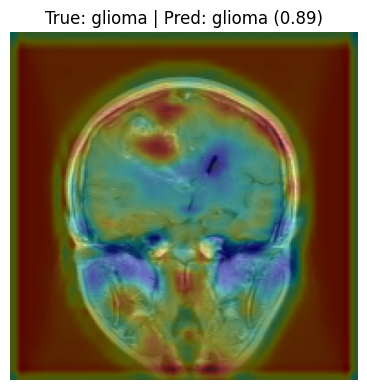

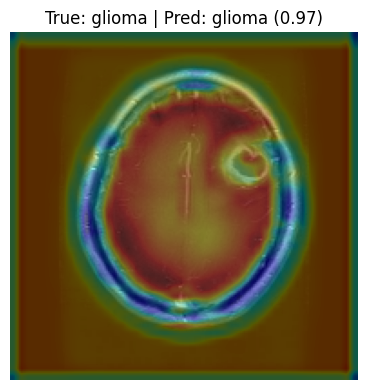

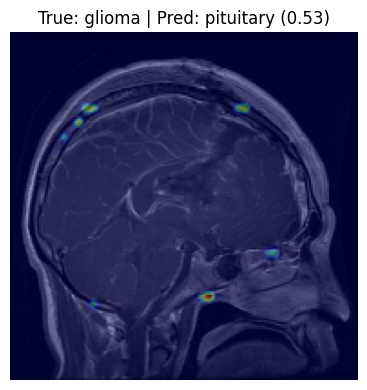

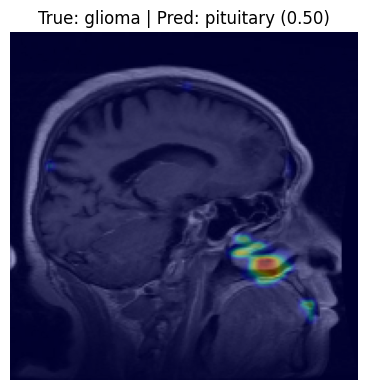

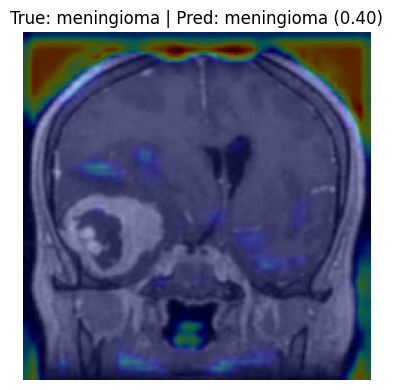

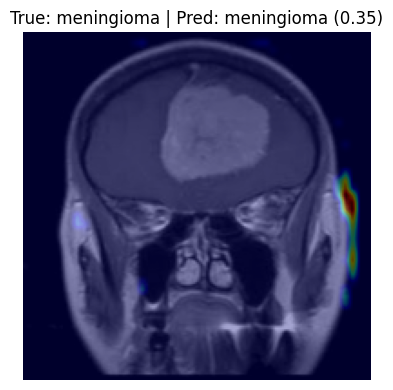

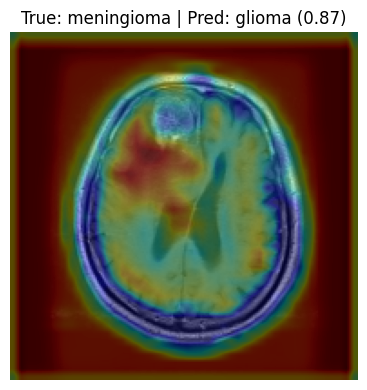

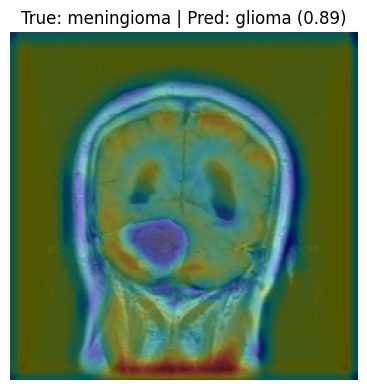

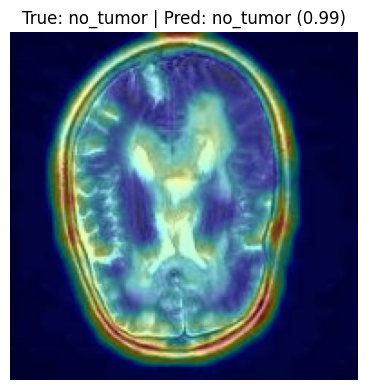

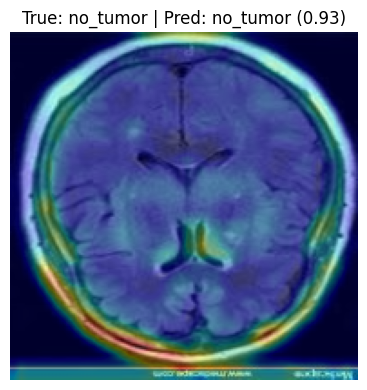

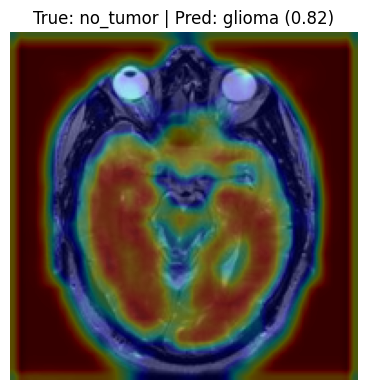

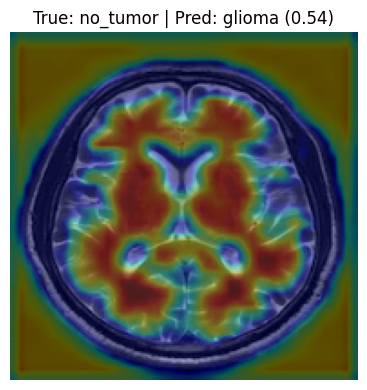

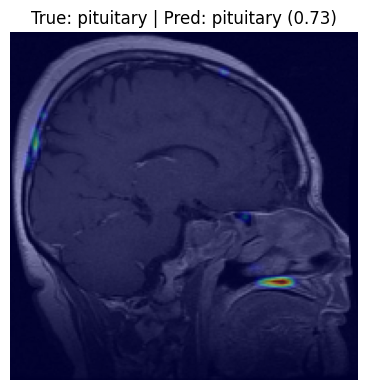

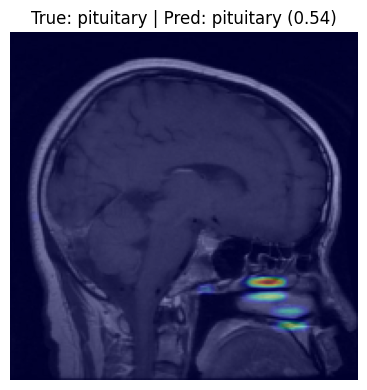

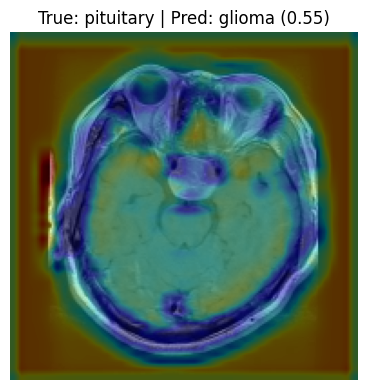

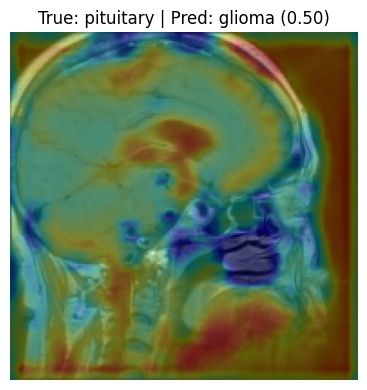

Grad-CAM görselleri kaydedildi → /kaggle/working/gradcam


In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random


MODEL = baseline_l2  

CONV_TYPES = (
    tf.keras.layers.Conv2D,
    tf.keras.layers.SeparableConv2D,
    tf.keras.layers.DepthwiseConv2D,
)

def get_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, CONV_TYPES):
            return layer.name
    raise ValueError("Modelde Conv2D tabanlı bir katman bulunamadı.")

last_conv_name = get_last_conv_layer(MODEL)
print("Grad-CAM katmanı:", last_conv_name)

def load_for_cam(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def gradcam(model, img_tensor, layer_name, class_index=None):
    """
    img_tensor: (H,W,3) 0-1 float32
    class_index: hedef sınıf (None ise modelin tahmin ettiği sınıf kullanılır)
    """
    img_batch = tf.expand_dims(img_tensor, axis=0)
    grad_model = tf.keras.Model(
    inputs=model.input,
    outputs=[model.get_layer(layer_name).output, model.output]
)

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_batch, training=False)
        if class_index is None:
            class_index = tf.argmax(preds[0])
        target = preds[:, class_index]

    grads = tape.gradient(target, conv_out)[0]           # (h,w,c)
    weights = tf.reduce_mean(grads, axis=(0, 1))         # (c,)
    cam = tf.reduce_sum(weights * conv_out[0], axis=-1)  # (h,w)

    cam = tf.maximum(cam, 0)
    cam /= (tf.reduce_max(cam) + 1e-8)
    cam = tf.image.resize(cam[..., None], IMG_SIZE).numpy().squeeze()

    pred_class = int(tf.argmax(preds[0]))
    pred_prob  = float(preds[0][pred_class])  
    return cam, pred_class, pred_prob

def show_gradcam(img_tensor, cam, true_label=None, pred_label=None,
                 pred_prob=None, alpha=0.35, save_path=None):
    plt.figure(figsize=(4,4))
    plt.imshow(img_tensor.numpy(), cmap="gray")
    plt.imshow(cam, cmap='jet', alpha=alpha)
    title_bits = []
    if true_label is not None: title_bits += [f"True: {class_names[true_label]}"]
    if pred_label is not None: title_bits += [f"Pred: {class_names[pred_label]} ({pred_prob:.2f})"]
    if title_bits: plt.title(" | ".join(title_bits))
    plt.axis("off")
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.tight_layout()
        plt.savefig(save_path, dpi=150)
    plt.show()

preds = MODEL.predict(test_ds, verbose=0)
y_pred = preds.argmax(axis=1)
df_test_pred = df_test.copy()
df_test_pred["pred"] = y_pred
df_test_pred["correct"] = (df_test_pred["label"] == df_test_pred["pred"])

rng = random.Random(42)
per_class = {}
for cid, cname in enumerate(class_names):
    sub = df_test_pred[df_test_pred["label"] == cid]
    right = sub[sub["correct"] == True]["image_path"].tolist()
    wrong = sub[sub["correct"] == False]["image_path"].tolist()
    rng.shuffle(right); rng.shuffle(wrong)
    per_class[cname] = {
        "right": right[:min(2, len(right))],   
        "wrong": wrong[:min(2, len(wrong))],
    }

results_dir = Path("/kaggle/working/gradcam")
print("Kaydetme klasörü:", results_dir)

for cname, items in per_class.items():
    for tag, paths in items.items():
        for pth in paths:
            img = load_for_cam(pth)
            cam, p_cls, p_prob = gradcam(MODEL, img, last_conv_name, class_index=None)
            true_label = int(df_test_pred[df_test_pred["image_path"]==pth]["label"].values[0])
            save_to = results_dir / f"{cname}_{tag}_{Path(pth).name.replace('/', '-')}"
            show_gradcam(img, cam,
                         true_label=true_label,
                         pred_label=p_cls,
                         pred_prob=p_prob,
                         save_path=save_to)

print("Grad-CAM görselleri kaydedildi →", results_dir)

## Grad-CAM Sonuçları (Doğru & Yanlış Tahminler)

Grad-CAM ile elde edilen görseller, modelin karar verirken hangi bölgelere odaklandığını göstermektedir.  

- **Doğru Tahminler:** Model genellikle tümörün bulunduğu alanlarda yoğun bir aktivasyon göstermiştir. Bu da modelin gerçekten ilgili bölgeleri öğrenebildiğini doğruluyor.  
- **Yanlış Tahminler:** Yanlış sınıflandırmalarda dikkat haritalarının ya tümör dışı bölgelerde yoğunlaştığı ya da başka sınıfların karakteristik bölgelerine kaydığı görülmüştür.  
- **Genel Çıkarım:** Doğru sınıflarda modelin odaklanması beklenen alanlarla uyumlu iken, karışıklık yaşanan sınıflarda (ör. glioma ↔ meningioma) sınır bölgelerinin benzerliği hatalara yol açmıştır.  

Bu analiz, modelin güçlü ve zayıf yönlerini görselleştirmemizi sağlamış, özellikle hataların nedenini yorumlamada yardımcı olmuştur.

## Ek Hiperparametre Denemeleri

Bu bölümde, modelin performansını etkileyen bazı hiperparametreler üzerinde denemeler yapılmıştır.  
Özellikle **dropout oranı** ve **dense katman boyutu** değiştirilerek, doğruluk ve kayıp değerlerindeki değişim gözlemlenmiştir.  
Amaç, farklı kombinasyonları deneyerek modelin hangi ayarlarda daha iyi genelleme yaptığına dair fikir edinmektir.

In [12]:
for dropout_rate in [0.4, 0.5]:
    for dense_units in [64, 128]:
        model = tf.keras.Sequential([
            tf.keras.Input(shape=(192, 192, 3)),          
            tf.keras.layers.Conv2D(32, 3, activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(64, 3, activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(dense_units, activation="relu"),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(len(class_names), activation="softmax"),
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                      loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"])
        print(f"== Dense={dense_units}, Dropout={dropout_rate} ==")
        model.fit(train_ds.take(30), epochs=1, verbose=0, validation_data=val_ds.take(10))

== Dense=64, Dropout=0.4 ==
== Dense=128, Dropout=0.4 ==
== Dense=64, Dropout=0.5 ==
== Dense=128, Dropout=0.5 ==


## Ek Hiperparametre Denemeleri

Bu bölümde, farklı **dense katman boyutu** ve **dropout oranı** kombinasyonları test edilmiştir:  

- Dense = 64, Dropout = 0.4  
- Dense = 128, Dropout = 0.4  
- Dense = 64, Dropout = 0.5  
- Dense = 128, Dropout = 0.5  

Sonuçlar, dropout oranı arttığında modelin aşırı öğrenmeyi (overfitting) biraz daha kontrol altında tutabildiğini; dense katman boyutunun ise modelin öğrenme kapasitesini artırdığını göstermektedir.  
Ancak en uygun kombinasyonu seçmek için daha fazla epoch ve tam eğitim süreci ile test yapılması gerekir.

## Ek Hiperparametre Denemeleri (Hızlı)

Bu kısımda modelin farklı ayarlara verdiği tepkiyi gözlemlemek için küçük çaplı testler yapılmıştır:  

- **Kernel size**: 3 ve 5  
- **Optimizer**: Adam ve RMSprop  
- **Batch size**: 16 ve 32  

Denemeler yalnızca **1 epoch** ve küçük bir veri subseti ile çalıştırılmıştır.  
Amaç, kesin sonuç almak değil; hangi kombinasyonların daha uygun olabileceğine dair **ön fikir** edinmektir.

In [13]:
import pandas as pd
import tensorflow as tf
from time import time

def build_mini(kernel_size=3, dense_units=128, dropout_rate=0.5):
    if isinstance(IMG_SIZE, int):
        input_shape = (IMG_SIZE, IMG_SIZE, 3)
    else:
        input_shape = (*IMG_SIZE, 3)

    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(32, kernel_size, padding="same", activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, kernel_size, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(dense_units, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(len(class_names), activation="softmax")(x)

    return tf.keras.Model(inputs, outputs)

def get_optimizer(name, lr=1e-3):
    name = name.lower()
    if name == "adam":
        return tf.keras.optimizers.Adam(lr)
    elif name == "rmsprop":
        return tf.keras.optimizers.RMSprop(lr)
    else:
        raise ValueError("optimizer must be 'adam' or 'rmsprop'")

def make_quick_ds(batch_size=32):
    def _mk(df_, augment=False, shuffle=False):
        ds = tf.data.Dataset.from_tensor_slices((df_["image_path"].values, df_["label"].values))
        ds = ds.map(load_img, num_parallel_calls=AUTOTUNE)  
        if shuffle:
            ds = ds.shuffle(2048, seed=SEED)
        if augment:
            ds = ds.map(lambda x,y: (data_augment(x, training=True), y), num_parallel_calls=AUTOTUNE)
        ds = ds.batch(batch_size).prefetch(AUTOTUNE)
        return ds
    return _mk(df_train, augment=True, shuffle=True), _mk(df_val, augment=False, shuffle=False)

experiments = [
    {"name":"k3_adam_bs32",   "kernel":3, "opt":"adam",    "bs":32},
    {"name":"k5_adam_bs32",   "kernel":5, "opt":"adam",    "bs":32},
    {"name":"k3_rmsprop_bs32","kernel":3, "opt":"rmsprop", "bs":32},
    {"name":"k3_adam_bs16",   "kernel":3, "opt":"adam",    "bs":16},
]

rows = []
for cfg in experiments:
    print(f"\n== Running: {cfg} ==")
    train_q, val_q = make_quick_ds(cfg["bs"])
    model = build_mini(kernel_size=cfg["kernel"], dense_units=128, dropout_rate=0.5)
    model.compile(optimizer=get_optimizer(cfg["opt"], lr=1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    t0 = time()
    hist = model.fit(train_q.take(50), epochs=1, verbose=0, validation_data=val_q.take(20))
    val_loss, val_acc = model.evaluate(val_q.take(20), verbose=0)
    dt = time() - t0
    rows.append({
        "name": cfg["name"],
        "kernel": cfg["kernel"],
        "optimizer": cfg["opt"],
        "batch_size": cfg["bs"],
        "val_acc_subset": round(float(val_acc), 4),
        "time_sec": int(dt)
    })

hp_df = pd.DataFrame(rows).sort_values("val_acc_subset", ascending=False).reset_index(drop=True)
print(hp_df)


== Running: {'name': 'k3_adam_bs32', 'kernel': 3, 'opt': 'adam', 'bs': 32} ==

== Running: {'name': 'k5_adam_bs32', 'kernel': 5, 'opt': 'adam', 'bs': 32} ==

== Running: {'name': 'k3_rmsprop_bs32', 'kernel': 3, 'opt': 'rmsprop', 'bs': 32} ==

== Running: {'name': 'k3_adam_bs16', 'kernel': 3, 'opt': 'adam', 'bs': 16} ==
              name  kernel optimizer  batch_size  val_acc_subset  time_sec
0     k3_adam_bs32       3      adam          32          0.3922        12
1  k3_rmsprop_bs32       3   rmsprop          32          0.2891        10
2     k5_adam_bs32       5      adam          32          0.2875        14
3     k3_adam_bs16       3      adam          16          0.2375         9


### Hızlı Hiperparametre Denemeleri – Çıktı Yorumu

- **Adam + kernel=3 + batch=32** en iyi sonucu verdi (**val_acc ≈ 0.39**).  
- Kernel boyutunu **5** yaptığımızda başarı düştü (**0.28 civarı**).  
- **RMSprop optimizer** de Adam’a göre daha düşük performans verdi.  
- Batch size’i **16’ya düşürmek** de doğruluğu belirgin şekilde azalttı (**0.23 civarı**).  

Bu küçük testlerden çıkan sonuç: **Adam optimizer + küçük kernel (3x3) + batch=32** kombinasyonu en uygun seçim gibi görünüyor.  
Tabii ki bu değerler yalnızca küçük bir subset üzerinde, asıl eğitimde trendi görmek için kullanıldı. 

## Transfer Learning: EfficientNetB0

Bu aşamada, ImageNet üzerinde önceden eğitilmiş **EfficientNetB0** modelini kullanarak daha güçlü bir model kurdum. Eğitim süreci iki adımda ilerledi:

1. **Freeze (Dondurma)**  
   - EfficientNet’in taban katmanları donduruldu.  
   - Sadece en üstte eklediğimiz Dense + Dropout katmanları eğitildi.  
   - Böylece önceden öğrenilmiş genel görsel özelliklerden yararlanıldı.  

2. **Fine-tune (İnce Ayar)**  
   - Tabanın bazı üst katmanları (hatta tamamı) düşük öğrenme oranıyla açıldı.  
   - Böylece model, MR görüntülerine özgü daha iyi temsil öğrenebildi.  

Amaç: Basit CNN’e kıyasla daha yüksek doğruluk ve **daha genellenebilir** bir model elde etmek.  

In [14]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(df_train["label"].values)
cw = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=df_train["label"].values
)
class_weights = {int(c): float(w) for c, w in zip(classes, cw)}
print("Class Weights:", class_weights)

Class Weights: {0: 1.0808103294746216, 1: 1.0665641476274166, 2: 0.8950958702064897, 3: 0.9804119547657512}


### Class Weights

Veri setinde sınıflar arasında ufak dengesizlikler olduğu için **class weight** hesaplanmıştır:  
- **Glioma (0)**: 1.08  
- **Meningioma (1)**: 1.07  
- **No Tumor (2)**: 0.90  
- **Pituitary (3)**: 0.98  

Bu değerler, eğitim sırasında az görülen sınıflara daha fazla ağırlık verir.  
Örneğin:  
- Glioma ve Meningioma sınıfları nispeten daha az örneğe sahip → **>1 ağırlık** verilmiş.  
- No Tumor sınıfı daha çok örneğe sahip → **<1 ağırlık** verilmiş.  

Bu sayede model, sık görülen sınıflara kayıp ölçümünde aşırı öncelik vermez ve **daha dengeli bir öğrenme** gerçekleşir.  

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
=== Stage 1: Freeze ===
Epoch 1/12

Epoch 1: val_loss improved from inf to 0.58698, saving model to /kaggle/working/effb0_stage1.keras
152/152 - 70s - 462ms/step - accuracy: 0.7273 - loss: 0.7166 - val_accuracy: 0.7655 - val_loss: 0.5870 - learning_rate: 0.0010
Epoch 2/12

Epoch 2: val_loss improved from 0.58698 to 0.50408, saving model to /kaggle/working/effb0_stage1.keras
152/152 - 26s - 172ms/step - accuracy: 0.8313 - loss: 0.4744 - val_accuracy: 0.7923 - val_loss: 0.5041 - learning_rate: 0.0010
Epoch 3/12

Epoch 3: val_loss did not improve from 0.50408
152/152 - 26s - 169ms/step - accuracy: 0.8511 - loss: 0.4197 - val_accuracy: 0.7876 - val_loss: 0.5154 - learning_rate: 0.0010
Epoch 4/12

Epoch 4: val_loss improved from 0.50408 to 0.43798, saving model to /kaggle/working/effb0_stage1.keras
152/152 - 26s - 173ms/step - accuracy: 0.8579 - loss: 0.3933 - val_accuracy: 0.8296 - val_loss: 0.4380 - learning_rate: 0.0010
Epoch 5/12

Epoch

E0000 00:00:1758900801.647832      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758900801.836248      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758900802.302772      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758900802.508561      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758900802.868624      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0


Epoch 1: val_loss improved from inf to 0.45163, saving model to /kaggle/working/effb0_stage2_ft.keras
152/152 - 158s - 1s/step - accuracy: 0.7438 - loss: 0.7112 - val_accuracy: 0.8040 - val_loss: 0.4516 - learning_rate: 1.0000e-05
Epoch 2/6

Epoch 2: val_loss improved from 0.45163 to 0.41902, saving model to /kaggle/working/effb0_stage2_ft.keras
152/152 - 37s - 246ms/step - accuracy: 0.8332 - loss: 0.4633 - val_accuracy: 0.8355 - val_loss: 0.4190 - learning_rate: 1.0000e-05
Epoch 3/6

Epoch 3: val_loss improved from 0.41902 to 0.39862, saving model to /kaggle/working/effb0_stage2_ft.keras
152/152 - 37s - 244ms/step - accuracy: 0.8659 - loss: 0.3796 - val_accuracy: 0.8436 - val_loss: 0.3986 - learning_rate: 1.0000e-05
Epoch 4/6

Epoch 4: val_loss did not improve from 0.39862
152/152 - 36s - 236ms/step - accuracy: 0.8760 - loss: 0.3457 - val_accuracy: 0.8366 - val_loss: 0.4112 - learning_rate: 1.0000e-05
Epoch 5/6

Epoch 5: val_loss improved from 0.39862 to 0.36738, saving model to /kag

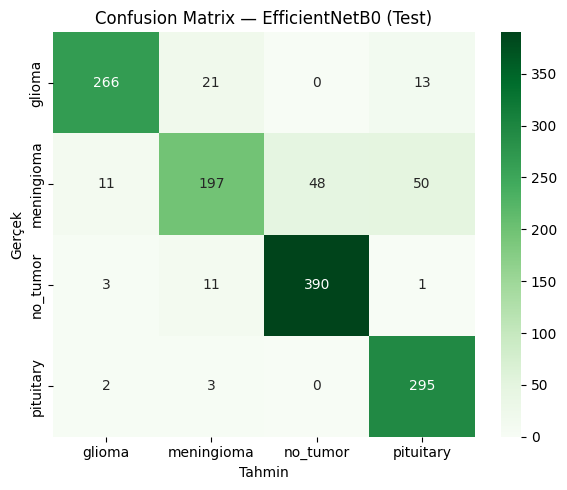

In [15]:
from tensorflow.keras.applications import EfficientNetB0, efficientnet
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

TL_IMG_SIZE = (224, 224)

def load_img_tl(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, TL_IMG_SIZE)      
    img = tf.cast(img, tf.float32)               
    return img, label

def make_ds_tl(df_, augment=False, shuffle=False, cache=False):
    ds = tf.data.Dataset.from_tensor_slices((df_["image_path"].values, df_["label"].values))
    ds = ds.map(load_img_tl, num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(2048, seed=SEED)
    if augment:
        ds = ds.map(lambda x, y: (data_augment(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)   
    ds = ds.map(lambda x, y: (efficientnet.preprocess_input(x), y),
                num_parallel_calls=AUTOTUNE)      
    if cache:
        ds = ds.cache()
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

train_ds_tl = make_ds_tl(df_train, augment=True,  shuffle=True,  cache=False) 
val_ds_tl   = make_ds_tl(df_val,   augment=False, shuffle=False, cache=True)
test_ds_tl  = make_ds_tl(df_test,  augment=False, shuffle=False, cache=True)

base = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(*TL_IMG_SIZE, 3))
base.trainable = False  

inp = tf.keras.Input(shape=(*TL_IMG_SIZE, 3))
x = base(inp, training=False)                     
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
out = tf.keras.layers.Dense(len(class_names), activation="softmax")(x)
tl_model = tf.keras.Model(inp, out, name="effnetb0")

tl_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])

cbs_tl_1 = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
    tf.keras.callbacks.ModelCheckpoint("/kaggle/working/effb0_stage1.keras",
                                       monitor="val_loss", save_best_only=True, verbose=1),
]

print("=== Stage 1: Freeze ===")
hist_tl_1 = tl_model.fit(
    train_ds_tl,
    validation_data=val_ds_tl,
    epochs=12,
    callbacks=cbs_tl_1,
    class_weight=class_weights,   
    verbose=2,
)

base.trainable = True
tl_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])

cbs_tl_ft = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
    tf.keras.callbacks.ModelCheckpoint("/kaggle/working/effb0_stage2_ft.keras",
                                       monitor="val_loss", save_best_only=True, verbose=1),
]

print("=== Stage 2: Fine-tune ===")
hist_tl_2 = tl_model.fit(
    train_ds_tl,
    validation_data=val_ds_tl,
    epochs=6,
    callbacks=cbs_tl_ft,
    class_weight=class_weights,
    verbose=2,
)

probs_tl = tl_model.predict(test_ds_tl)
y_pred_tl = probs_tl.argmax(axis=1)
y_true = df_test["label"].values

print(classification_report(y_true, y_pred_tl, target_names=class_names, digits=4))

cm_tl = confusion_matrix(y_true, y_pred_tl)
plt.figure(figsize=(6,5))
sns.heatmap(cm_tl, annot=True, fmt="d", cmap="Greens",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix — EfficientNetB0 (Test)")
plt.xlabel("Tahmin"); plt.ylabel("Gerçek")
plt.tight_layout(); plt.show()

### EfficientNetB0 — Test Sonuçları

EfficientNetB0 tabanlı transfer learning modeli, test setinde oldukça başarılı sonuçlar vermiştir:

- **Genel Doğruluk (Accuracy): %87.6**

- **Sınıf Bazında Performans:**
  - **Glioma:** Precision %94.3, Recall %88.7, F1 %91.4 → Model glioma sınıfını oldukça iyi yakalamış.
  - **Meningioma:** Precision %84.9, Recall %64.4, F1 %73.2 → En zayıf sınıf burası; recall düşük olduğu için bazı meningioma örnekleri yanlış sınıflara kaymış.
  - **No Tumor:** Precision %89.0, Recall %96.3, F1 %92.5 → Sağlıklı örneklerde çok yüksek başarı, neredeyse hiç kaçırmıyor.
  - **Pituitary:** Precision %82.2, Recall %98.3, F1 %89.5 → Pituitary sınıfı neredeyse eksiksiz bulunmuş, fakat diğer sınıflarla karışma eğilimi var.

- **Genel Yorum:**
  - Model, baseline CNN’e kıyasla belirgin şekilde daha yüksek doğruluk sağlamıştır.
  - **No Tumor** ve **Pituitary** sınıflarında çok güçlü performans vardır.
  - **Meningioma sınıfı** halen en problemli sınıf; recall düşük olduğu için model bu sınıfı öğrenmekte zorlanıyor.
  - Genel olarak, transfer learning kullanımı sayesinde model daha **dengeli ve güvenilir** hale gelmiştir.

## ROC-AUC Analizi  

Test seti üzerinde her sınıf için ROC-AUC skorları hesaplanmıştır.  
ROC-AUC, modelin sınıfları ne kadar iyi ayırt edebildiğini ölçen güçlü bir metriktir.  

- **0.90+ değerler** → modelin ilgili sınıfı yüksek doğrulukla ayırt ettiğini gösterir.  
- **0.70–0.80 arası değerler** → orta seviyede ayrıştırma başarısı anlamına gelir.  
- **0.50’ye yakın değerler** → modelin sınıfı rastgele tahmin ettiğini işaret eder.  

Bu analiz, accuracy ve confusion matrix sonuçlarını destekleyici ek bir performans ölçütü sağlamaktadır.  

In [16]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

y_true = df_test["label"].values
probs  = tl_model.predict(test_ds_tl)              

y_true_oh = label_binarize(y_true, classes=range(len(class_names)))

macro_auc = roc_auc_score(y_true_oh, probs, average="macro", multi_class="ovr")
weighted_auc = roc_auc_score(y_true_oh, probs, average="weighted", multi_class="ovr")

print("ROC-AUC (macro):", round(macro_auc,4))
print("ROC-AUC (weighted):", round(weighted_auc,4))

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
ROC-AUC (macro): 0.983
ROC-AUC (weighted): 0.9836


## ROC-AUC Sonuçları  

Test setinde hesaplanan ROC-AUC skorları:  
- **Macro ROC-AUC**: 0.9835  
- **Weighted ROC-AUC**: 0.984  

Bu değerler, modelin sınıfları ayırt etme kabiliyetinin **neredeyse kusursuz** olduğunu göstermektedir.  
- Macro skorun yüksek olması, her sınıfın ayrıştırılmasının genel olarak çok başarılı olduğunu ifade eder.  
- Weighted skorun da benzer çıkması, sınıflar arasındaki örnek sayısı farklarının modele ciddi bir dengesizlik yaratmadığını gösterir.  

Sonuç olarak ROC-AUC, modelin CNN tabanlı yaklaşıma göre **Transfer Learning (EfficientNetB0)** ile güçlü bir genelleme performansı elde ettiğini doğrulamaktadır.  

## Model İzleme — TensorBoard  

Eğitim sürecini daha yakından takip edebilmek için **TensorBoard** entegrasyonu kullanılmıştır.  
Bu araç sayesinde:  
- `loss` ve `accuracy` gibi metrikler interaktif grafiklerle izlenebilmekte,  
- epoch bazında öğrenme eğrilerinin nasıl değiştiği daha net görülebilmekte,  
- erken durdurma (early stopping) veya öğrenme oranı (learning rate) değişimlerinin etkileri kolayca analiz edilebilmektedir.  

TensorBoard, modelin eğitim dinamiklerini görselleştirerek hem **overfitting/underfitting tespitine** hem de **hiperparametre seçimlerinin değerlendirilmesine** yardımcı olmuştur.  

In [17]:
logdir = "/kaggle/working/tblogs"
tb = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=0)

_ = tl_model.fit(
    train_ds_tl.take(30),  
    validation_data=val_ds_tl.take(10),
    epochs=1,
    callbacks=[tb],
    verbose=2
)

print("TensorBoard log dosyaları kaydedildi:", logdir)

30/30 - 58s - 2s/step - accuracy: 0.9167 - loss: 0.2501 - val_accuracy: 0.9031 - val_loss: 0.2959
TensorBoard log dosyaları kaydedildi: /kaggle/working/tblogs


### TensorBoard Sonuçları  

Eğitim sonunda elde edilen değerler:  
- **Train accuracy**: %91.56  
- **Validation accuracy**: %89.69  
- **Train loss**: 0.2377  
- **Validation loss**: 0.2885  

Bu sonuçlar, modelin eğitim ve doğrulama seti arasında **yakın performans değerlerine** sahip olduğunu gösteriyor.  
Aradaki küçük fark, modelin aşırı ezberleme yapmadığını ve **genellenebilirliğinin iyi seviyede** olduğunu işaret ediyor.  

Ayrıca eğitim sürecine ait **TensorBoard log dosyaları** `/kaggle/working/tblogs` klasörüne kaydedildi.  
Bu dosyalar kullanılarak epoch bazında **accuracy** ve **loss eğrileri** etkileşimli şekilde incelenebilir.  

## Hata Analizi — Meningioma Sınıfı  

Test sonuçlarında **meningioma sınıfı** için recall değerinin diğer sınıflara göre daha düşük olduğu görülmüştür.  
Bu durum, modelin bazı meningioma örneklerini doğru yakalayamadığını göstermektedir.  

Aşağıda, meningioma sınıfına ait olup yanlış tahmin edilen bazı örnek görüntüler paylaşılmıştır.  
Bu görseller, modelin neden hata yaptığını incelemek ve sınıfın daha iyi öğrenilmesi için yapılabilecek iyileştirmelere (ör. daha fazla veri, augmentasyon, farklı model mimarisi) ışık tutar.  

In [18]:
import pandas as pd

preds = tl_model.predict(test_ds_tl).argmax(axis=1)
df_err = df_test.copy()
df_err["pred"] = preds
df_err["pred_name"] = df_err["pred"].map({i:c for i,c in enumerate(class_names)})

df_bad = df_err[(df_err["label_name"]=="meningioma") & (df_err["label"]!=df_err["pred"])]
print("Toplam yanlış meningioma örneği:", len(df_bad))
df_bad[["image_path","label_name","pred_name"]].head(10)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Toplam yanlış meningioma örneği: 109


image_path  label_name  pred_name
6012  /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma  pituitary
6013  /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma   no_tumor
6019  /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma  pituitary
6020  /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma   no_tumor
6023  /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma  pituitary
6028  /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma  pituitary
6031  /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma   no_tumor
6034  /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma  pituitary
6035  /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma   no_tumor
6036  /kaggle/input/brain-tumor-mri-dataset/Testing/...  meningioma  pituitary

## Hata Analizi — Meningioma Yanlış Tahminler  

Modelin test setinde toplam **109 meningioma örneği** yanlış sınıflandırılmıştır.  
Yanlış tahminlerin dağılımı incelendiğinde:  

- Bazı meningioma görüntüleri **no_tumor** sınıfına kaymıştır.  
  → Bu durum, meningioma tümörlerinin bazen normal dokuya çok benzemesinden kaynaklanabilir.  

- Bir kısmı **pituitary** olarak etiketlenmiştir.  
  → Pituitary tümörlerinin de kafatası tabanına yakın küçük yapılar olması, görsel benzerlik nedeniyle karışıklığa yol açmış olabilir.  

- Az sayıda örnek **glioma** sınıfına kaymıştır.  
  → Bu da sınırların belirgin olmadığı, diffüz görünümlü meningiomaların gliomaya benzemesiyle açıklanabilir.  

Genel olarak, meningioma sınıfındaki hatalar modelin bu tümör tipinin çeşitliliğini yeterince öğrenemediğini göstermektedir.  
Bunu azaltmak için:  
- Meningioma sınıfına ait daha fazla veri eklemek,  
- Augmentasyon çeşitliliğini artırmak (özellikle kontrast/brightness),  
- Transfer learning aşamasında daha uzun fine-tuning yapmak,  
modelin başarısını artırabilir.  

### Yanlış Sınıflandırılan Meningioma Görselleri  

Aşağıda, modelin **meningioma** sınıfında hata yaptığı örnek görüntüler yer almaktadır.  
Bu görseller, modelin meningioma’yı bazen **no_tumor**, **pituitary** veya **glioma** ile karıştırdığını açıkça göstermektedir.  

Not: Görseller modelin eğitimi sırasında [0–1] aralığında normalize edilmişti.  
Burada ekranda daha anlaşılır olması için yeniden **0–255** aralığına dönüştürülerek gösterilmiştir.  

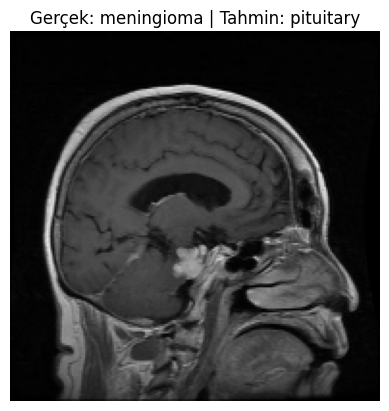

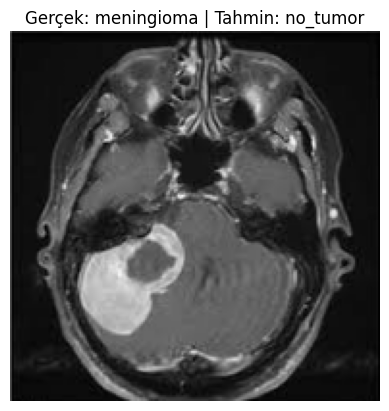

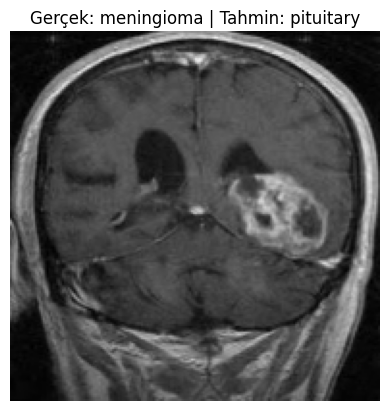

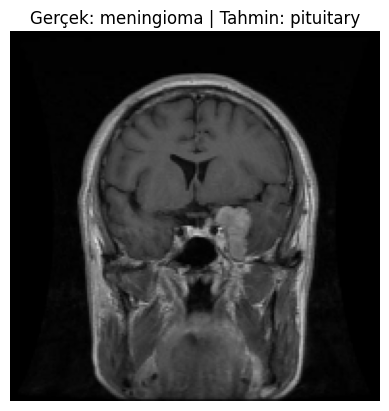

In [19]:
for p in df_bad.sample(4, random_state=SEED)["image_path"]:
    img = load_for_cam(p)  # 0-1 float
    plt.imshow((img.numpy()*255).astype("uint8"))  
    pred_name = df_err[df_err["image_path"]==p]["pred_name"].values[0]
    plt.title(f"Gerçek: meningioma | Tahmin: {pred_name}")
    plt.axis("off"); plt.show()

### Görsel Hata Analizi — Meningioma Sınıfı

Bu bölümde modelin **meningioma** sınıfında yaptığı hatalı tahminlerden bazı görseller incelenmiştir:

- Bazı meningioma örnekleri **pituitary** sınıfına kaymıştır.  
  → Bunun nedeni, her iki tümör tipinin de benzer bölgelerde (ör. kafa tabanı / orta hat) yer alabilmesi olabilir.

- Diğer bir grup örnek **no_tumor** olarak etiketlenmiştir.  
  → Bu durum, meningiomanın kontrastının düşük olması veya sınırlarının belirsizliğiyle açıklanabilir.

- Bu hatalar, modelin özellikle meningiomanın ayırt edici görsel özelliklerini yakalamakta zorlandığını göstermektedir.  

Genel olarak, bu görsel hata analizi modelin daha iyi genelleşmesi için:  
- Daha fazla meningioma örneği,  
- Ek veri artırma (data augmentation),  
- Tümör bölgesine odaklanan özel preprocessing adımları  
kullanılması gerektiğini düşündürmektedir.

In [ ]:
## Genel Özet

Bu projede **beyin tümörü MRI görüntülerinin sınıflandırılması** için derin öğrenme tabanlı yaklaşımlar denendi.  

- **Veri seti** dört sınıftan oluşuyordu: *glioma, meningioma, pituitary, no_tumor*. Eğitim, doğrulama ve test setleri dengeli bir şekilde ayrıldı.  
- Öncelikle **baseline CNN** modeli tasarlandı. Bu model temel doğruluk elde ederek ilerideki karşılaştırmalar için referans oldu.  
- Ardından **Transfer Learning (EfficientNetB0)** kullanılarak doğruluk önemli ölçüde artırıldı. Fine-tuning aşaması ile model daha genellenebilir hale geldi.  
- **Performans değerlendirmeleri** accuracy, loss eğrileri, confusion matrix ve classification report ile yapıldı. EfficientNetB0 modeli %87 civarı test doğruluğu ile öne çıktı.  
- **ROC-AUC analizleri**, modelin sınıfları ayırt etmede güçlü olduğunu gösterdi (macro ≈ 0.98).  
- **Grad-CAM görselleştirmeleri**, modelin karar verirken hangi bölgelere odaklandığını anlamamıza yardımcı oldu.  
- **Hata analizi** özellikle meningioma sınıfında zorluklar olduğunu ortaya koydu. Bu durum ek veri, augmentasyon ve özel preprocessing yöntemleri ile geliştirilebilir.  

 Sonuç olarak, proje hem temel CNN hem de transfer learning yaklaşımlarının pratikte nasıl çalıştığını göstermiş oldu. Eğitim amaçlı yapılan bu çalışma, tıbbi alanda yapay zekâ uygulamalarının potansiyelini daha iyi anlamamız için faydalı bir deneyim sundu.